# Image Analysis for Geospatial Application

## Lab 3: Deep Learning & Pixelwise classification

Please enter your data below (double click to edit the table).

| Name  | Matr.-nr. |
|-|-|
| your name | 12345 |

`In this lab, you will implement a Convolutional Neural Network (CNN) classifier and apply it to the MNIST dataset for image categorization. Then, you will build a semantic segmentation model using an encoder-decoder architecture and investigate some approaches for improving the classification results.`

__Libraries__ required for this lab can be installed by;
1. Visiting and following the instructions at [pytorch.org](https://pytorch.org/get-started/locally/) to see how __Pytorch__ and __Torchvision__ modules can be installed. The CUDA tab refers to the support of GPUs. Unless you have experience with the CUDA framework select `None` here.

2. Running ``!pip install segmentation-models-pytorch``. [__Segmentation-models-pytorch__](https://github.com/qubvel/segmentation_models.pytorch#installation) is a high level API for creating neural network with few lines of code.

Required __imports__ and __settings__ for this lab:

In [1]:
# IMPORTS
# General
import lab                                       # Given functions
import numpy as np                               # Numerical computations
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib                                # Plots
import matplotlib.pyplot as plt    

import random
from functools import partial
from os.path import join as pjoin

# Deep Learning
import torch                                     # PyTorch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import transforms as TF
from torchvision.transforms import functional as TFF

import segmentation_models_pytorch as smp        #  Segmentation-models-pytorch

# GLOBAL SETTINGS
PlotSize = 7                                     # Size of plots
matplotlib.rcParams['figure.figsize'] = [PlotSize, PlotSize] 
CMAP = plt.cm.Accent                             # Color mapping 
np.set_printoptions(precision=3)                 # Array print precision
np.random.seed(0)

# Switch to CPU when GPU is not available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the checkpoints folder
lab.create_checkpoints_folder()

## Exercise 1: Image classification - (30%)

We are going to use the  [MNIST dataset](http://yann.lecun.com/exdb/mnist/) alreadey used in the previous lab. The dataset contains images of hand written digits, each having 28 x 28 pixel and one channel. The classes correspond to the digits 0-9. The given function `lab.MnistGenerator()` will download the dataset (if not already available). The images in the MNIST dataset is already split into:

- 60.000 images for training
- 10.000 images for testing
- 1.000 images for validation

Run the next cell to visualize a few data samples from training. You can run the cell several times to see some digits:

In [ ]:
gen = lab.MnistGenerator()
Xs, Ys = gen.get_train_batch()

figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
print('Examples of digits:')

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(Xs), size=(1,)).item()
    img, label = Xs[sample_idx], Ys[sample_idx]
    title = "Class {}:".format(label)
    figure.add_subplot(rows, cols, i)
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Exercise 1.1: Defining the models  - 10%

We will train the LeNet model on the dataset as described below:

__Convolutional neural network:__

- Implement the LeNet architecture
- For convolutions use `nn.Conv2d(...)`
- For max pooling use `F.max_pool2d(...)` (size is 2x2 and stride is also 2)
- Use `torch.relu` as non-linearity.


#### Hints:

- In each forward pass __normalize__ the images to a range of -1 to 1 (input values are in the range between 0 and 255).
- Use `x=x.view(-1, N)` to __flatten__ a feature map (with `N` elements). This is required when passing images or feature maps to dense (fully connected) layers.
- Take a look at the pytorch documentation about the usage of convolutions and pooling.
- __The last layer must not have a non-linearity__ (because the softmax is included in the loss formulation we will use later)
- The LeNet architecture is shown in the following image:

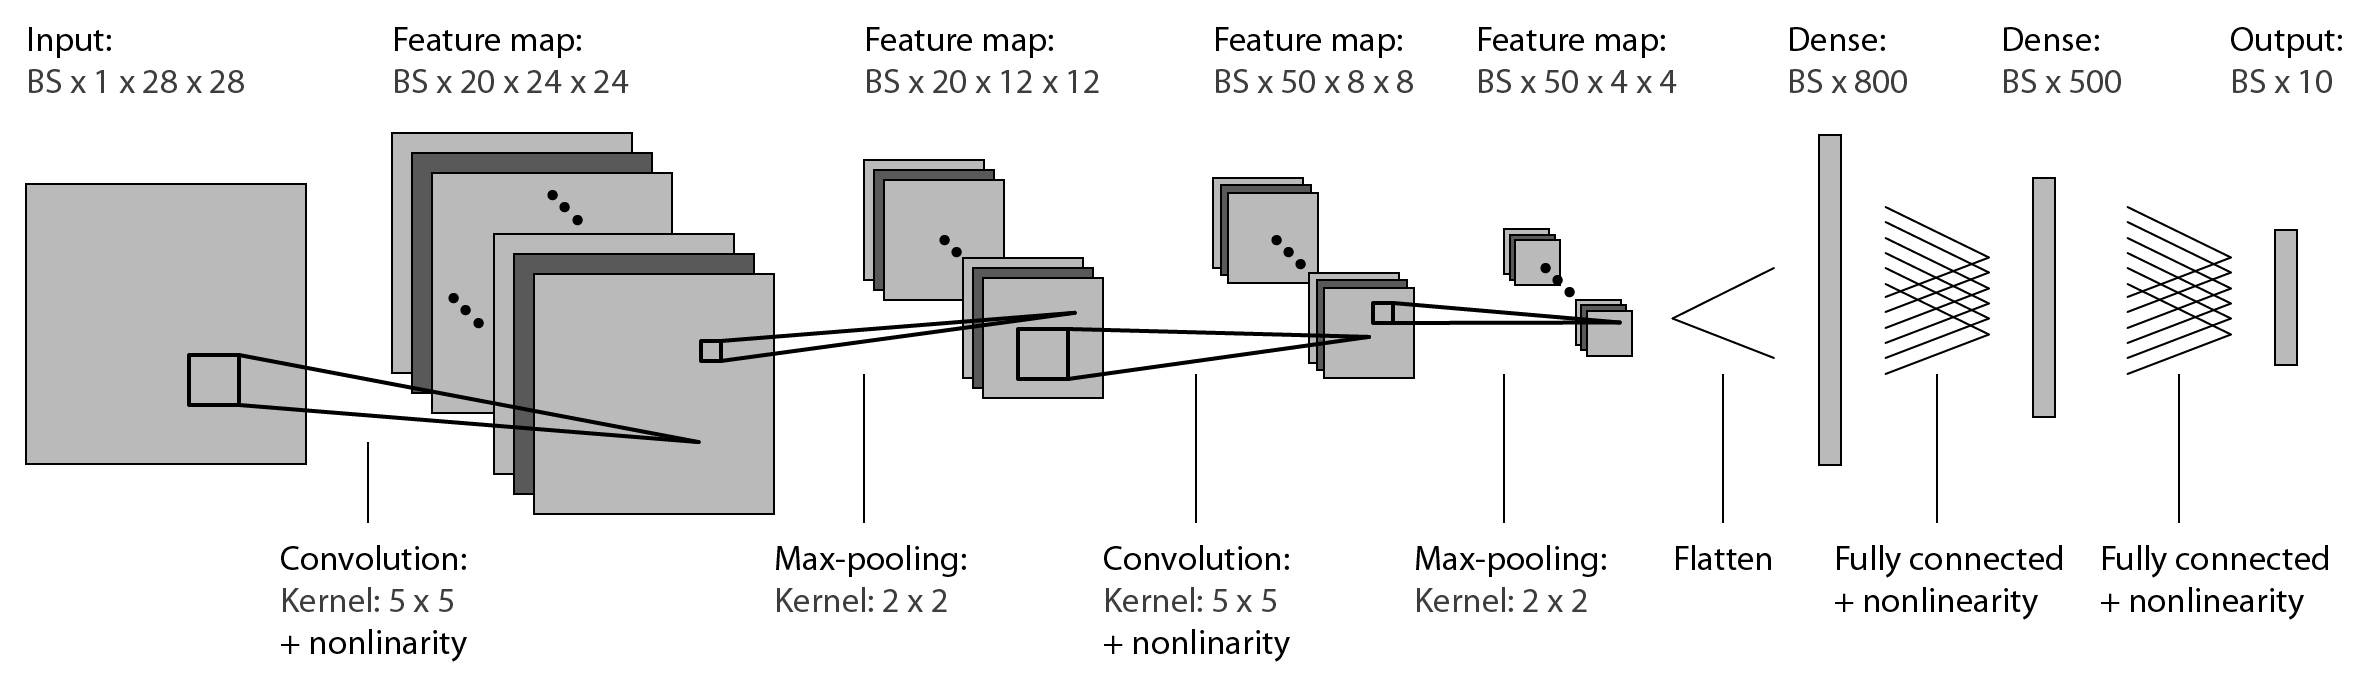

__Implement__ the model in the next cell. 


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        
        # YOUR CODE GOES HERE
        
    def forward(self, x):
        
        # YOUR CODE GOES HERE
        
        return x

#### Training loop

The training loop including evaluation on the validation and test sets is given in the next cell.

In [ ]:
def train_network(gen, net, optimizer, num_iter):
    Ls = []     # Losses
    TBAs = []   # Training (Batch) Accuracy
    VAs = []    # Final Validation Accuracy
    
    net.train()
    criterion = nn.CrossEntropyLoss() # This criterion computes the cross entropy loss between input logits and target.
                                      # It combines Softmax and Cross Entropy Loss
    for i in range(num_iter):
        X, Y = gen.get_train_batch()
        num_samples = float(len(Y))
        
        TX = torch.tensor(X).view(-1, 1, 28, 28)
        TY = torch.tensor(Y).long()
        
        optimizer.zero_grad()  
        pred = net(TX)
        loss = criterion(pred, TY)
        loss.backward()
        optimizer.step()  

        Vs, Is = torch.max(pred, -1)
        num_correct = np.sum(Is.data.numpy() == Y)
        TBA = num_correct/num_samples
        print('\rIt {}/{}, CE: {:.3f}, Batch Acc.: {}/{} = {:.1%}'.format(
            i, num_iter, loss.data, num_correct, len(Y), TBA), end='')
        
        # Compute accuracy of validation set
        
        X, Y = gen.get_validation_batch()
        num_samples = float(len(Y))
        TX = torch.tensor(X).view(-1, 1, 28, 28)
        TY = torch.tensor(Y).long()
        net.eval()
        pred = net(TX)
        net.train()
        Vs, Is = torch.max(pred, -1)
        num_correct = np.sum(Is.data.numpy() == Y)
        VA = num_correct/num_samples
        
        Ls.append(float(loss.data))
        TBAs.append(TBA)
        VAs.append(VA)
        
    # Compute accuracy on test set
        
    X, Y = gen.get_test_batch()
    TX = torch.tensor(X).view(-1, 1, 28, 28)
    TY = torch.tensor(Y).long()
    net.eval()
    pred = net(TX)
    Vs, Is = torch.max(pred, -1)

    CM = confusion_matrix(Y, Is)
    return Ls, TBAs, VAs, CM

### Exercise 1.2: Training  - 10%

In the next cell,  the model is trained. __Choose appropriate hyperparameters__ to achieve stable results. In particular choose:

- Batch size `BS`
- Number of iterations `IT`
- Learning rate `LR`

#### Training LeNet

In [ ]:
BS = 
LR = 
IT = 

gen = lab.MnistGenerator(BS) 
net = LeNet() 
optimizer = optim.SGD(net.parameters(), lr=LR)

Ls, TBAs, VAs, CM = train_network(gen, net, optimizer, IT)
lab.print_summary(Ls, TBAs, VAs, CM)

#### Training LeNet with few data
in the next setup, reduce the number of training samples until signs of overfitting are visible.

In [ ]:
BS = 
LR = 
IT = 
num_training_samples = # Try values in the range of  1-3 times the BS 

gen = lab.MnistGenerator(BS, num_train=num_training_samples) # Data generator
net = LeNet() 
optimizer = optim.SGD(net.parameters(), lr=LR)

Ls, TBAs, VAs, CM = train_network(gen, net, optimizer, IT)
lab.print_summary(Ls, TBAs, VAs, CM)

### Exercise 1.3: Discussion  - 10%

__Write a discussion__ which answers the following questions: 

- What is the main influence of learning rate and batch size you could observe during the experiments?
- What can be observed when using too few training data? Which approaches exist to improve training with few samples? (That is, without modifying the hyper-parameters related to the training!)
- Why is the pooling operation used in LeNet? Name the two main reasons as well as an alternative approach for pooling.


*Do not forget to answer all questions, item by item, and to identify which answer belongs to which question.*

## Exercise 2: Pixelwise classification - (40%)

In this exercise, we will use the [UAVID](https://uavid.nl/) dataset. It contains images of urban street scenes and is designed for semantic segmentation. The classes correspond to eight categories (Building, Road, Static car, Tree, Low vegetation, Human, Moving car and Background). The given function `lab.UaVidDataset()` will load the preprocessed dataset. The preprocessed images in the UAVID dataset are already split into:

- 140 images for training
- 70 images for validation
- 60 images for testing

The next cell will download the `UAVID Dataset`and place it into your working directory. The folder `UAVID Datase` contains both the preprocessed __mini_uavid__ images and __uavid_pkl__ folders.

__Lab assignment tree__ should look as follows:
```bash
├── Lab_3
│   ├── deep_learning_and_pixel_wise_classification.ipynb
│   ├── lab.py
│   ├── mini_uavid
│   ├── uavid_pkl
│   ├── images       # where the network architectures are located
│   └── checkpoints  # where the parameters of the models are saved

```

In [ ]:
# # create the "Data" folder if it does not exist
lab.create_data_folder()

# Download the dataset as a zip file
lab.download_data_from_seafile(data_url, local_filename)

# Unzip the downloaded zip file
lab.unzip_file(local_filename, output_folder)

In the next cell, we define a colour code for the classes, and choose to ignore the class `Background (clutter)` for this exercise.

In [ ]:
colours = np.array(
    [[128, 0, 0],   # Building
    [128, 64, 128], # Road
    [0, 128, 0],    # Tree
    [128, 128, 0],  # Low vegetation
    [64, 64, 0],    # Human
    [64, 0, 128],   # Moving car
    [192, 0, 192],  # Static car
    [0, 0, 0],      # Background (clutter)
])

class_names = ['Building', 'Road', 'Tree', 'Low vegetation', 'Human', 'Moving car', 'Static car']

num_cls   = 7       # number of classes
ign_index = 7       # ignore index (for this lab, 'Background (clutter)' is ignored)

# Function converts ID-maps to coloured label maps

def idmap2labelmap(idmap):
    h,w = idmap.shape[:2]
    labelmap = colours[idmap.reshape(-1)].reshape((h,w,3))
    return labelmap

__Run__ the following cell to load the preprocessed data for training, validation and testing


In [ ]:
train_dataset    = lab.UaVidDataset('train')
val_dataset      = lab.UaVidDataset('val')
test_dataset     = lab.UaVidDataset('test')

print(f'Training samples   : {len(train_dataset)}')
print(f'Validation samples : {len(val_dataset)}')
print(f'Testing samples    : {len(test_dataset)}')

Let us randomly choose and visualize an example.

In [ ]:
sample = train_dataset[3]
image, idmap = sample['image'], sample['idmap']
imgvisu = image.data.numpy().transpose(1,2,0)
labelmap = idmap2labelmap(idmap[0,:,:].data.numpy())

plt.imshow(imgvisu); plt.title('Image captured by UAV'); plt.show()
plt.imshow(labelmap); plt.title('Ground truth labels'); plt.show()

### Exercise 2.1: Defining a  U-Net model from scratch  - 10%

We will train an:

__Encoder - Decoder Neural network:__

- Implement the U-Net architecture as shown in the image below and use the module `DoubleConv(...)` for building blocks
- For max pooling use `F.max_pool2d(...)` (size is 2x2 and stride width is also 2)
- For up-sampling by bilinear interpolation use `F.interpolate (...)` (with 'bilinear' as interpolation mode and a scale factor of 2)
- Use the function `torch.cat(...)` for implementing skip connections by concatenating features from corresponding blocks in the encoder and the decoder).

Here is an example of a "submodule" that is used several times in the actual U-Net

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_chnls, out_chnls):
        super().__init__()
        Conv2d33 = partial(nn.Conv2d, kernel_size=3, padding=1)
    
        self.seq = nn.Sequential(Conv2d33(in_chnls, out_chnls), nn.ReLU(inplace=True),
                                Conv2d33(out_chnls, out_chnls), nn.ReLU(inplace=True))
    def forward(self, x):
        return self.seq(x)

Implementation of the UNet

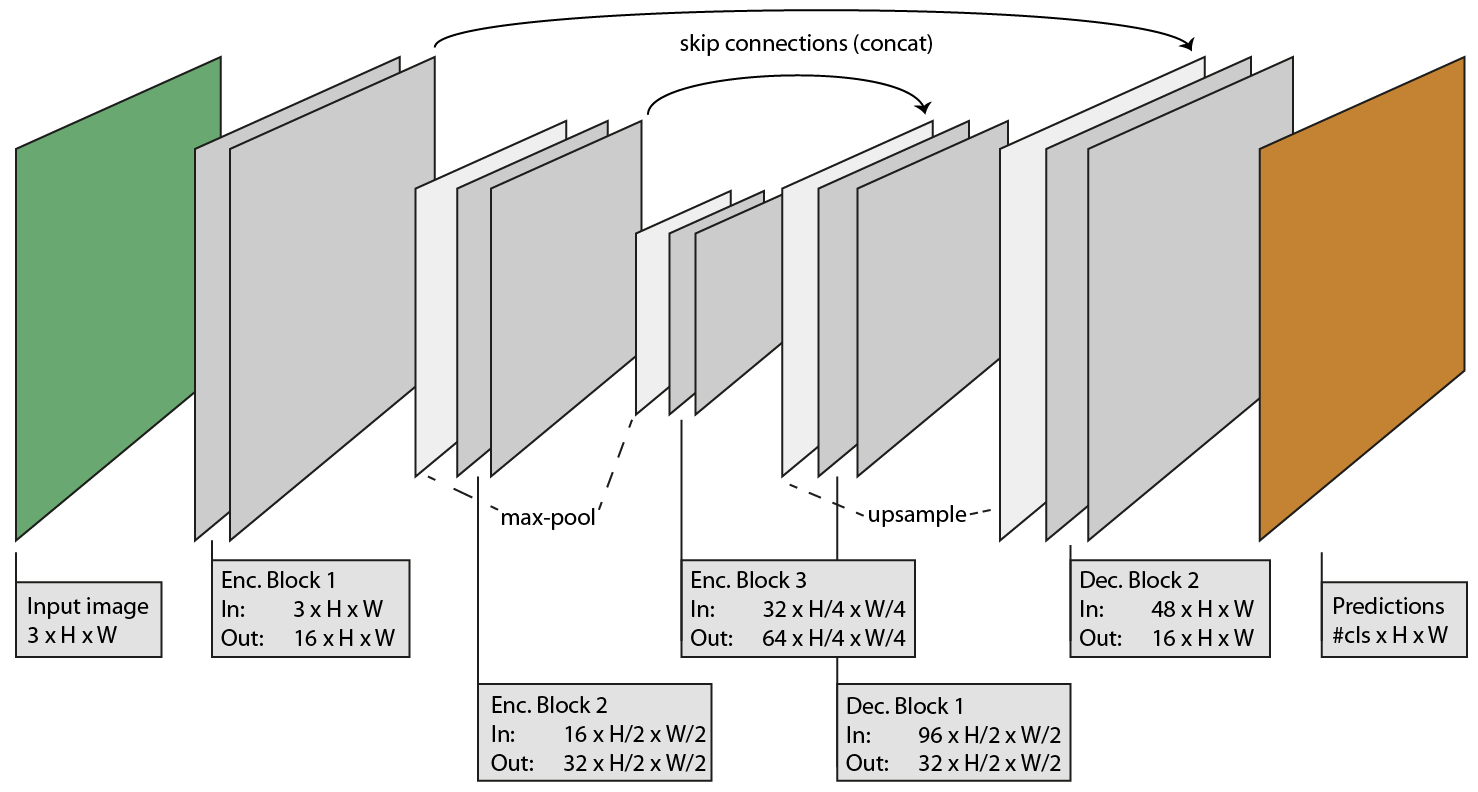

Use the next cell to __implement__ the model: 

In [ ]:
# UNet model!

class UNet(nn.Module):
    def __init__(self):
        
        # YOUR CODE GOES HERE
        
    def forward(self, x):
        
        # YOUR CODE GOES HERE
        return x

### Exercise 2.2: Training - 10%

__Complete__ the function `train_network()` where the U-Net model is trained for `num_epochs` epochs using the Adam optimizer `optimizer` and a learning rate of `l_r`. After training has finished, the function should perform an evaluation based on the validation set, compute the confusion matrix and return the `current validation mean f1 score (mf1)`. Refer to the `lab.eval_net()` method and its associated functions to learn how to obtain the quality metrics from the confusion matrix.

By default, tensors are generated in the CPU. Even the model is initialized in the CPU. To allow the execution of a larger number of calculations in parallel, it is possible to opt for the use of the GPU. Therefore, our code has been adapted to use the GPU (if available) to make the neural network training much faster. For example, `image.to(device.type)` generate the tensor in the GPU if a GPU is available and in the CPU otherwise.

__Training Loop__

In [ ]:
# training loop for a given number of epochs

def train_network(network, train_dataloader, val_dataloader, optimizer, num_epochs):
    
    max_val_score = 0.0
        
    # YOUR CODE GOES HERE!
    # Hint:
    #     loop over number of epochs
    #     Loss models are used to compute the loss, here: CrossEntropyLoss; nn.CrossEntropyLoss(ignore_index=7) # Supervised loss
    #     print Training loss after each epoch
    #
    # Compute accuracy on the validation set using the lab.eval_net()
    #    function, which can be found in the lab.py
    # 
    #
    # Optional: Save the best parameters of your trained model for further use
    if mf1 > max_val_score:
        print('New best parameters saved!')
        max_val_score = mf1
        model_name = network.name.lower()
        lab.save_net(network, f'{model_name}_val_{ep}')
    
    # return the mean f1 score
    return mf1

__Run__ the next cell to instantiate data loaders:

In [ ]:
# Instantiation of the data-loaders for all subsets using PyTorch high-level API

train_dataloader = DataLoader(train_dataset,  num_workers=0, batch_size=1, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

#### Training U-Net

Train the network model for __THREE__ epochs. This may take several minutes.

In [ ]:
l_r           = 0.001 
num_epochs    =  # fill-in to train the network for three epochs

# instantiate the model
unet = Unet(3, num_cls) # 3 here is the number of channels for the input image

# Set model name for saving best parameters 
unet.name = 'UNET'

_ = unet.to(device.type)

# Adam optimiser
optimiser = optim.Adam(unet.parameters(), lr=l_r) 

# Training
train_network(unet, train_dataloader, val_dataloader,  optimiser, num_epochs) 

In [ ]:
# Uncomment the next line (if you have already trained the model) to load the best saved params
# lab.load_net(unet, 'unet_val_num_epochs') # 'unet_val_num_epochs' here is the saves params

# Inference
f1s_unet = lab.eval_net(unet, test_dataloader, 'f1s')

__Run__ the next cell to visualize __predictions__ and display __F1-scores__ for each class for U-Net:

In [ ]:
sample = val_dataset[15]
image, idmap = sample['image'], sample['idmap']
image_prep = image[np.newaxis,:,:,:].to(device.type)
pred = torch.argmax(unet(image_prep), axis=1)

imgvisu = image.data.numpy().transpose(1,2,0)
labelmap = idmap2labelmap(idmap[0,:,:].data.numpy())
predvisu_unet = idmap2labelmap(pred[0,:,:].cpu().data.numpy())

plt.imshow(imgvisu);   plt.title('Image captured by UAV'); plt.axis('off'); plt.show()
plt.imshow(predvisu_unet);  plt.title('Predicted labels'); plt.axis('off'); plt.show()
plt.imshow(labelmap); plt.title('Ground truth labels'); plt.axis('off'); plt.show()

In [ ]:
print('F1-Scores')
for c_name, score in zip(class_names, f1s_unet):
    print(f'{score:.2%} - {c_name}')
print(f'\nAverage f1s {np.mean(f1s_unet):.2%}')

### Exercise 2.3: Discussion - 20%

__Write a discussion__ which answers the following questions: 

- Discuss the models' performance.
- What are the motivations for using skip connections?
- Which classes are problematic and why do you think this is the case?
- Describe two methods for changing the model architecture to help the CNN to generalize well.



*Do not forget to answer all questions, item by item, and to identify which answer belongs to which question.*

## Exercise 3. Improving the classifier - (30%)

### Exercise 3.1:  Data augmentation - 10%


The Pytorch framework provides a flexible way to perform image transformations through its module __torchvision.transforms__ (check https://pytorch.org/vision/stable/transforms.html for more details). Run the next cell to apply some transformations to the images:  

In [ ]:
# Adjust the brightness and contrast of the image

def augmentation_radiometric(sample):
    image, idmap = sample['image'], sample['idmap']

    image = TFF.adjust_brightness(image, brightness_factor = random.randint(8, 12)/10.0)
    image = TFF.adjust_contrast(image, contrast_factor = random.randint(8, 12)/10.0)
    
    return {'image':image, 'idmap':idmap}


# Rotate the image by angle
def augmentation_geometric(sample):
    image, idmap = sample['image'], sample['idmap']

    angle = random.randint(-10, 10)
    image = TFF.rotate(image, angle)
    idmap = TFF.rotate(idmap, angle, fill=ign_index)
    
    if random.random() > 0.5:
        image = TFF.hflip(image)
        idmap = TFF.hflip(idmap)
        
    h,w = image.size()[1:]
    ph = h - h%32
    pw = w - w%32
    
    cx = random.randint(0, h-ph)
    cy = random.randint(0, w-pw)
    
    image = TFF.crop(image, cx, cy, ph, pw)
    idmap = TFF.crop(idmap, cx, cy, ph, pw)
        
    return {'image':image, 'idmap':idmap}

In [ ]:
# Putting the two transformations into a single function
def augmentation(sample):
    sample = augmentation_geometric(sample)
    sample = augmentation_radiometric(sample)
    return sample

# Upper left cropping
def upper_left_crop(sample):
    image, idmap = sample['image'], sample['idmap']

    h,w = image.size()[1:]
    
    ph = h - h%32
    pw = w - w%32
       
    image = TFF.crop(image, 0, 0, ph, pw)
    idmap = TFF.crop(idmap, 0, 0, ph, pw)
        
    return {'image':image, 'idmap':idmap}

In the next cell, __apply__ the `augmentation()` function on the training data and the function `upper_left_crop()`  to both validation and testing sets to __INITIALISE loaders__. Remender to set `shuffle=True` for the training set to opt to shuffle the data during each epoch.

In [ ]:
# YOUR CODE GOES HERE!

# Hints: Refer to how we instantiated data samples for training UNet
      # 1. Apply the augmentation to the training samples
      # 2. Apply the upper left cropping to the validation samples
      # 3. Apply the upper left cropping to the test samples


__Run__ the next cell to check your loaders with augmentation.

In [ ]:
sample = train_dataset_aug[0]
image, idmap = sample['image'], sample['idmap']

imgvisu = image.data.numpy().transpose(1,2,0)
labelmap = idmap2labelmap(idmap[0,:,:].data.numpy())
plt.title('Image captured by UAV')
plt.imshow(imgvisu)
plt.show()
plt.title('Ground truth labels')
plt.imshow(labelmap)

### Exercise 3.2: Training the new classifier  - 5%

One way to improve the accuracy of the classification is to use a powerful model. In this section, a pre-trained model is trained. __Run__ the next two cells to load and train the model for __1 epoch__ (otherwise this would take too long). 

Load a __stronger__ and __pre-trained__ backbone model. The model loaded here is a U-Net model with an X-Ception backbone defined in [pretrainedmodels](https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/xception.py#L114):

In [ ]:
import ssl

# Fixing URLError when loading pre-trained weights!
ssl._create_default_https_context = ssl._create_unverified_context

depth = 5
unet_pt = smp.Unet('xception', in_channels=3, classes=7, encoder_depth=depth,
                             decoder_channels=[256, 128, 64, 32, 16][-depth:], encoder_weights='imagenet')
# Set model name
unet_pt.name = 'UNET_PT'

_ = unet_pt.to(device.type)

In [ ]:
LR = 0.01
M  = 0.9
WD = 0.0
num_epochs =  # fill-in to train the network for one epoch

# Here SGD is used, because the backbone was pre-trained with SGD as well
optimiser = optim.SGD(unet_pt.parameters(), lr=LR, momentum=M, weight_decay=WD)

# Train dataloader should be the one with augmentation and val_dataloader with cropping
train_network(unet_pt, train_dataloader_aug, val_dataloader_crop, optimiser, num_epochs)

Now that you know how to re-train a pre-trained model, we will load stronger pretrained wights and run inference. The file `unet_pt_val_78.pt` __will be placed in the `checkpoints` folder__ where this notebook is run. 

The next cell will load those pre-trained weights and run inference on the test set:

In [ ]:
# Download the checkpoints
lab.download_checkpoints_from_seafile(ckpt_url, ckpt_save_path)

In [ ]:
# Load the pre-trained params
lab.load_net(unet_pt, f'unet_pt_val_78')

# Inference
f1s_unet_pt = lab.eval_net(unet_pt, test_dataloader_crop, 'f1s')

#### Visualising prediction

In [ ]:
sample = val_dataset_crop[15]
image, idmap = sample['image'], sample['idmap']
image_prep = image[np.newaxis,:,:,:].to( device.type)
pred = torch.argmax(unet_pt(image_prep), axis=1)

imgvisu = image.data.numpy().transpose(1,2,0)
labelmap = idmap2labelmap(idmap[0,:,:].data.numpy())
predvisu_unet_pt = idmap2labelmap(pred[0,:,:].cpu().data.numpy())

plt.imshow(imgvisu); plt.title('Image captured by UAV');  plt.axis('off'); plt.show()
plt.imshow(predvisu_unet_pt); plt.title('Predicted labels'); plt.axis('off'); plt.show()
plt.imshow(labelmap); plt.title('Ground truth labels'); plt.axis('off'); plt.show()

__Run__ the next cell to display __F1-scores__ for each class for U-Net  pretrained

In [ ]:
print('F1-Scores')
for c_name, score in zip(class_names, f1s_unet_pt):
    print(f'{score:.2%} - {c_name}')
print(f'\nAverage f1s {np.mean(f1s_unet_pt):.2%}')

Visual comparison to basic U-Net

In [ ]:
plt.imshow(predvisu_unet_pt); plt.title('Predicted labels with pre-trained U-Net'); plt.axis('off'); plt.show() 
plt.imshow(predvisu_unet);  plt.title('Predicted labels with U-Net'); plt.axis('off'); plt.show()
plt.imshow(labelmap); plt.title('Ground truth labels'); plt.axis('off'); plt.show()

### Exercise 3.3: Discussion - 15%

__Write a discussion__ which answers the following questions: 

- What is the purpose of using data augmentation  when training a Neural network? Are there any other data augmentation techniques (not implemented here) you think might be useful for this exercise? Why do you think this would be the case?
- What do we expect when applying pre-trained networks? 

*Do not forget to answer all questions, item by item, and to identify which answer belongs to which question.*